In [1]:
import os
import sys

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.utils.data as tdata
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import wandb

In [2]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from anime_face_generator.config import PROCESSED_DATA_DIR, RAW_DATA_DIR, MODELS_DIR

%load_ext autoreload
%autoreload 2

2025-08-05 10:40:33.889 | INFO     | anime_face_generator.config:<module>:11 - PROJ_ROOT path is: /home/ayoubvip/anime_face_generator


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("number of GPUs:", torch.cuda.device_count())

Using device: cuda
number of GPUs: 4


## Data augmentation

In [4]:
IMG_SIZE = (64, 64)
BATCH_SIZE = 10
IMG_CHANNELS = 3

IMG_DIM = IMG_SIZE[0] * IMG_SIZE[1] * IMG_CHANNELS

In [5]:
transformers = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=IMG_SIZE),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(10, fill=(255, 255, 255)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

dataset = torchvision.datasets.ImageFolder(root=PROCESSED_DATA_DIR, transform=transformers, target_transform=None)

In [6]:
rand_gen = torch.Generator().manual_seed(1978)

## Architecture

In [7]:
T = 1000  # total diffusion steps
BETA_START = 1e-4
BETA_END = 0.02

# Linear noise schedule
beta = torch.linspace(BETA_START, BETA_END, T, device=device)       # β_t ∈ (0.0001, 0.02)
alpha = 1. - beta                           # α_t = 1 - β_t
alpha_bar = torch.cumprod(alpha, dim=0)     # \bar{α}_t = product of α_1 to α_t

# model_params:
model_config = {
  "im_channels" : IMG_CHANNELS,
  "im_size" : IMG_SIZE[0],
  "down_channels" : [32, 64, 128, 256],
  "mid_channels" : [256, 256, 128],
  "down_sample" : [True, True, False],
  "time_emb_dim" : 128,
  "num_down_layers" : 2,
  "num_mid_layers" : 2,
  "num_up_layers" : 2,
  "num_heads" : 4,
}



#   down_channels : [32, 64, 128, 256]
#   mid_channels : [256, 256, 128]
#   down_sample : [True, True, False]


# Checking dimension consistency
assert model_config["mid_channels"][0] == model_config["down_channels"][-1]
assert model_config["mid_channels"][-1] == model_config["down_channels"][-2]

# train_params:
#   task_name: 'default'
#   batch_size: 64
#   num_epochs: 40
#   num_samples : 100
#   num_grid_rows : 10
#   lr: 0.0001
#   ckpt_name: 'ddpm_ckpt.pth'

In [8]:

def get_time_embedding(time_steps, temb_dim: torch.Tensor, device=device) -> torch.Tensor:
    r"""
    Convert time steps tensor into an embedding using the
    sinusoidal time embedding formula
    :param time_steps: 1D tensor of length batch size
    :param temb_dim: Dimension of the embedding
    :return: BxD embedding representation of B time steps
    """
    assert temb_dim % 2 == 0, "time embedding dimension must be divisible by 2"
    half_dim = temb_dim // 2
    # factor = 10000^(2i/d_model)
    factor = 10000 ** ((torch.arange(start=0, end=half_dim, dtype=torch.float32, device=device) / half_dim)
    )
    
    # pos / factor
    # timesteps B -> B, 1 -> B, temb_dim
    t_emb = time_steps[:, None].repeat(1, half_dim) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
    return t_emb


class DownBlock(nn.Module):
    r"""
    Down conv block with attention.
    Sequence of following block
    1. Resnet block with time embedding
    2. Attention block
    3. Downsample using 2x2 average pooling
    """
    def __init__(self, in_channels, out_channels, t_emb_dim,
                 down_sample=True, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.down_sample = down_sample
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for i in range(num_layers)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(8, out_channels)
             for _ in range(num_layers)]
        )
        
        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
             for _ in range(num_layers)]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels,
                                          4, 2, 1) if self.down_sample else nn.Identity()
    
    def forward(self, x, t_emb):
        out = x
        for i in range(self.num_layers):
            
            # Resnet block of Unet
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            # Attention block of Unet
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn
            
        out = self.down_sample_conv(out)
        return out


class MidBlock(nn.Module):
    r"""
    Mid conv block with attention.
    Sequence of following blocks
    1. Resnet block with time embedding
    2. Attention block
    3. Resnet block with time embedding
    """
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers+1)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers + 1)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers+1)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(8, out_channels)
                for _ in range(num_layers)]
        )
        
        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_layers)]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers+1)
            ]
        )
    
    def forward(self, x, t_emb):
        out = x
        
        # First resnet block
        resnet_input = out
        out = self.resnet_conv_first[0](out)
        out = out + self.t_emb_layers[0](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[0](out)
        out = out + self.residual_input_conv[0](resnet_input)
        
        for i in range(self.num_layers):
            
            # Attention Block
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn
            
            # Resnet Block
            resnet_input = out
            out = self.resnet_conv_first[i+1](out)
            out = out + self.t_emb_layers[i+1](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i+1](out)
            out = out + self.residual_input_conv[i+1](resnet_input)
        
        return out


class UpBlock(nn.Module):
    r"""
    Up conv block with attention.
    Sequence of following blocks
    1. Upsample
    1. Concatenate Down block output
    2. Resnet block with time embedding
    3. Attention Block
    """
    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample=True, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [
                nn.GroupNorm(8, out_channels)
                for _ in range(num_layers)
            ]
        )
        
        self.attentions = nn.ModuleList(
            [
                nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_layers)
            ]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2,
                                                 4, 2, 1) \
            if self.up_sample else nn.Identity()
    
    def forward(self, x, out_down, t_emb):
        x = self.up_sample_conv(x)
        x = torch.cat([x, out_down], dim=1)
        
        out = x
        for i in range(self.num_layers):
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn

        return out


class Unet(nn.Module):
    r"""
    Unet model comprising
    Down blocks, Midblocks and Uplocks
    """
    def __init__(self, model_config):
        super().__init__()
        im_channels = model_config['im_channels']
        self.down_channels = model_config['down_channels']
        self.mid_channels = model_config['mid_channels']
        self.t_emb_dim = model_config['time_emb_dim']
        self.down_sample = model_config['down_sample']
        self.num_down_layers = model_config['num_down_layers']
        self.num_mid_layers = model_config['num_mid_layers']
        self.num_up_layers = model_config['num_up_layers']
        
        assert self.mid_channels[0] == self.down_channels[-1]
        assert self.mid_channels[-1] == self.down_channels[-2]
        assert len(self.down_sample) == len(self.down_channels) - 1

        # Initial projection from sinusoidal time embedding
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )

        self.up_sample = list(reversed(self.down_sample))
        self.conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size=3, padding=(1, 1))

        self.downs = nn.ModuleList([])
        for i in range(len(self.down_channels)-1):
            self.downs.append(DownBlock(self.down_channels[i], self.down_channels[i+1], self.t_emb_dim,
                                        down_sample=self.down_sample[i], num_layers=self.num_down_layers))
        
        self.mids = nn.ModuleList([])
        for i in range(len(self.mid_channels)-1):
            self.mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i+1], self.t_emb_dim,
                                      num_layers=self.num_mid_layers))
        
        self.ups = nn.ModuleList([])
        for i in reversed(range(len(self.down_channels)-1)):
            self.ups.append(UpBlock(self.down_channels[i] * 2, self.down_channels[i-1] if i != 0 else 16,
                                    self.t_emb_dim, up_sample=self.down_sample[i], num_layers=self.num_up_layers))
        
        self.norm_out = nn.GroupNorm(8, 16)
        self.conv_out = nn.Conv2d(16, im_channels, kernel_size=3, padding=1)
    
    def forward(self, x, t):
        # Shapes assuming downblocks are [C1, C2, C3, C4]
        # Shapes assuming midblocks are [C4, C4, C3]
        # Shapes assuming downsamples are [True, True, False]
        # B x C x H x W
        out = self.conv_in(x)
        # B x C1 x H x W
        
        # t_emb -> B x t_emb_dim
        t_emb = get_time_embedding(torch.as_tensor(t, device=device).long(), self.t_emb_dim)
        t_emb = self.t_proj(t_emb)
        
        down_outs = []
        
        for idx, down in enumerate(self.downs):
            down_outs.append(out)
            out = down(out, t_emb)
        # down_outs  [B x C1 x H x W, B x C2 x H/2 x W/2, B x C3 x H/4 x W/4]
        # out B x C4 x H/4 x W/4
        
        for mid in self.mids:
            out = mid(out, t_emb)
        # out B x C3 x H/4 x W/4
        
        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)
            # out [B x C2 x H/4 x W/4, B x C1 x H/2 x W/2, B x 16 x H x W]
        out = self.norm_out(out)
        out = nn.SiLU()(out)
        out = self.conv_out(out)
        # out B x C x H x W
        return out
    
def q_sample(x0, t, noise=None): # add noise | forward pass | q(x_t | x_t-1)
    if noise is None:
        noise = torch.randn_like(x0).to(device)
    
    sqrt_alpha_bar = alpha_bar[t].sqrt().view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar = (1 - alpha_bar[t]).sqrt().view(-1, 1, 1, 1)
    
    return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise # <= x_t 

def get_loss(model, x0, t=None):
    B = x0.shape[0]
    if t is None:
        t = torch.randint(0, T, (B,), device=x0.device).long()
    noise = torch.randn_like(x0).to(device)
    x_t = q_sample(x0, t, noise).to(device)                       # q(x_t | x_t-1)
    pred_noise = model(x_t.to(device), t.to(device)).to(device)   # ε_θ(x_t, t) -->  time is embeded instead
    return nn.MSELoss()(pred_noise, noise), pred_noise, x_t

In [23]:
model = Unet(model_config).to(device)
backup_model = "2025-08-04_21-09-16_VDM_huge_tailored_advanced_UNET_model--good-denoising-medium-quality-generalization-1.07-epochs.pth"
# "40MB_ddpm_Unet_ckpt_epoch_4.pth"
# # 'good-denoising-bad-generalization--2025-08-02_20-59-28_VDM_advanced_UNET_model.pth'
model.load_state_dict(torch.load(MODELS_DIR / backup_model, weights_only=True))
num_model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_model_params / 1e6:.2f}M")

Number of trainable parameters: 10.19M


In [10]:
# BATCH_SIZE = 10
dataloader = tdata.DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=6,
    pin_memory=True
)

## Simpling from the learned distribution

In [11]:
@torch.no_grad()
def p_sample(model, x_t, t):
    beta_t = beta[t].view(-1, 1, 1, 1)
    sqrt_alpha_t = alpha[t].sqrt().view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar_t = (1 - alpha_bar[t]).sqrt().view(-1, 1, 1, 1)

    # Predict noise
    eps_theta = model(x_t, t)

    # Compute predicted x_0
    pred_x0 = (x_t - sqrt_one_minus_alpha_bar_t * eps_theta) / sqrt_alpha_t

    # Compute mean (μ_θ)
    mu = (1 / sqrt_alpha_t) * (x_t - beta_t / sqrt_one_minus_alpha_bar_t * eps_theta)

    # Sample noise (except for last step)
    if t[0] > 0:
        noise = torch.randn_like(x_t)
    else:
        noise = torch.zeros_like(x_t)

    x_prev = mu + beta_t.sqrt() * noise
    return x_prev.clamp(-1, 1)

In [12]:
@torch.no_grad()
def generate(model, shape=(1, 1, 64, 64)):
    x = torch.randn(shape).to(device)
    B = shape[0]    #batch size, number of samples to generate
    # Generate samples by reversing the diffusion process
    for t_step in reversed(range(T)):
        t = torch.full((B,), t_step, dtype=torch.long).to(device)
        x = p_sample(model, x, t)
    return x

In [24]:
@torch.no_grad()
def generate_samples(model, num_samples=48, image_size=IMG_SIZE):
    model.eval()
    samples = generate(model, shape=(num_samples, IMG_CHANNELS, *image_size))
    return samples

def show_images_grid_rgb(samples, nrow=8, ncol=6):
    fig, axes = plt.subplots(ncol, nrow, figsize=(nrow, ncol))
    samples = (samples + 1) / 2         # Rescale from [-1, 1] to [0, 1]
    samples = samples.clamp(0, 1).cpu() # Ensure valid pixel range
    samples = samples.permute(0, 2, 3, 1)  # Convert to (N, H, W, C) for plotting

    idx = 0
    for row in range(ncol):
        for col in range(nrow):
            axes[row, col].imshow(samples[idx])
            axes[row, col].axis('off')
            idx += 1
    plt.tight_layout()
    plt.show()

# Example usage:
samples = generate_samples(model, num_samples=3, image_size=IMG_SIZE)  # adapt shape to your dataset

IndexError: index 3 is out of bounds for dimension 0 with size 3

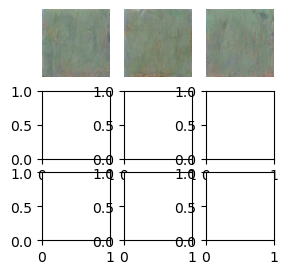

In [25]:
show_images_grid_rgb(samples, nrow=3, ncol=3)

In [ ]:
@torch.no_grad()
def sample_ddpm(model, n_samples, T, IMG_SIZE=(3, 64, 64)):
    model.eval()
    x_t = torch.randn(n_samples, *IMG_SIZE).to(device)

    for t in reversed(range(T)):
        t_tensor = torch.full((n_samples,), t, dtype=torch.long, device=device)

        beta_t = beta[t]
        alpha_t = alpha[t]
        alpha_bar_t = alpha_bar[t]
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar_t)
        sqrt_recip_alpha = torch.sqrt(1.0 / alpha_t)

        eps_theta = model(x_t, t_tensor)

        # Predict x0
        x0_pred = (x_t - sqrt_one_minus_alpha_bar * eps_theta) / torch.sqrt(alpha_bar_t)

        # Predict mean for x_{t-1}
        mean = sqrt_recip_alpha * (x_t - beta_t / sqrt_one_minus_alpha_bar * eps_theta)

        if t > 0:
            noise = torch.randn_like(x_t)
            sigma = torch.sqrt(beta_t)
            x_t = mean + sigma * noise
        else:
            x_t = mean  # final prediction

    return (x_t + 1) / 2  # rescale from [-1,1] to [0,1]

samples = generate_samples(model, num_samples=18, image_size=IMG_SIZE)  # adapt shape to your dataset
show_images_grid_rgb(samples, nrow=6, ncol=3)
# sample_ddpm(model, n_samples, T,IMG_SIZE)

In [ ]:
import time
label = "good-denoising-medium-quality-generalization-2.1-epochs"
model_name = time.strftime("%Y-%m-%d_%H-%M-%S") + f"_VDM_huge_tailored_advanced_UNET_model--{label}-" + ".pth"
torch.save(model.state_dict(), MODELS_DIR / model_name)
print("Saved PyTorch Model State to " +  model_name)

 ### Saving the notebook.

In [17]:
# %%javascript
# IPython.notebook.save_notebook()
from ipylab import JupyterFrontEnd
app = JupyterFrontEnd()
app.commands.execute('docmanager:save')